<a href="https://colab.research.google.com/github/yasirabd/sentiment-dkk-semarang/blob/main/notebooks/Sentiment_Analysis_DKK_Semarang_(TF_IDF_%26_SVM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install emoji

     |████████████████████████████████| 168 kB 12.1 MB/s 
  Created wheel for emoji: filename=emoji-1.6.0-py3-none-any.whl size=168256 sha256=3a91ee8f7b5fe0961b5c732f5ac2d54fefce0d47b96d647272eeb711e86d7f6f
  Stored in directory: /root/.cache/pip/wheels/f7/d7/74/c720aaf345a042b0c2d74361873258c5e8649b7f11b2ccce49
Successfully built emoji


# Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import string, re, requests, csv
from google.colab import drive
from wordcloud import WordCloud
from gensim.corpora import WikiCorpus

In [3]:
from nltk import word_tokenize, sent_tokenize
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load dataset

In [4]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

train.head()

,text,label,username,likes,datetime
0,🔥,negative,lanyardsemarang,0,2020-11-02
1,Naik Turun maju can5ik 😂😂😂😂,neutral,hadi_soeparno,1,2021-03-29
2,Prosentase tingkat kematian karena covid 19 ut...,neutral,heryadisaputro,0,2020-09-22
3,Rapid test/ test swab PCR Di DKK/dinkes Semara...,negative,airlangga15,0,2020-05-29
4,"Min, area pedurungan bs dilakukan dmn,",neutral,fauzanabell,0,2021-06-22


# EDA

## Wordcloud

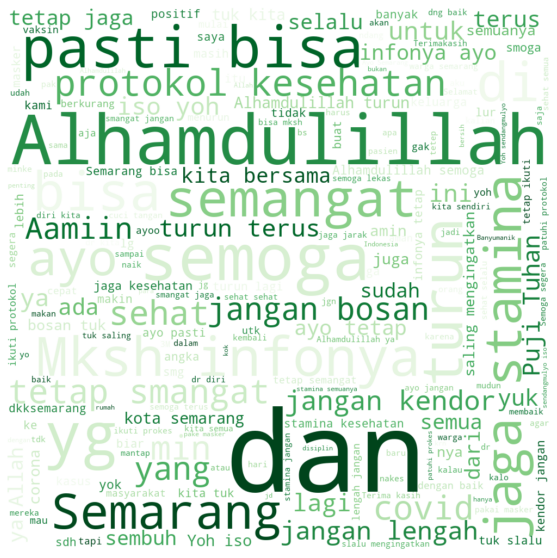

In [5]:
# positive comments before preprocessing
data_pos = train[train['label'] == 'positive']

all_text = ' '.join(word for word in data_pos['text'])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

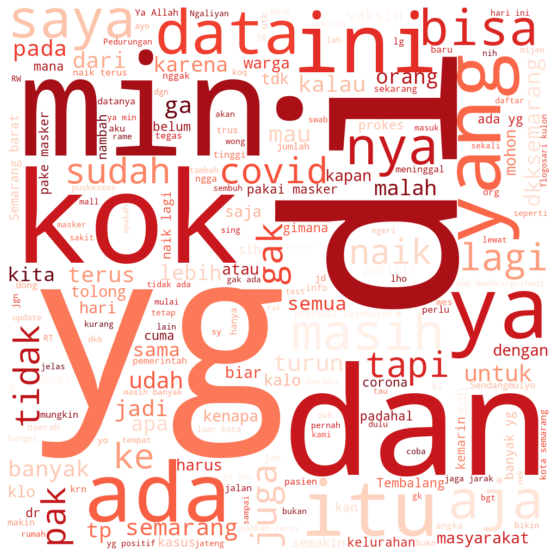

In [6]:
# negative comments before preprocessing
data_neg = train[train['label'] == 'negative']

all_text = ' '.join(word for word in data_neg['text'])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

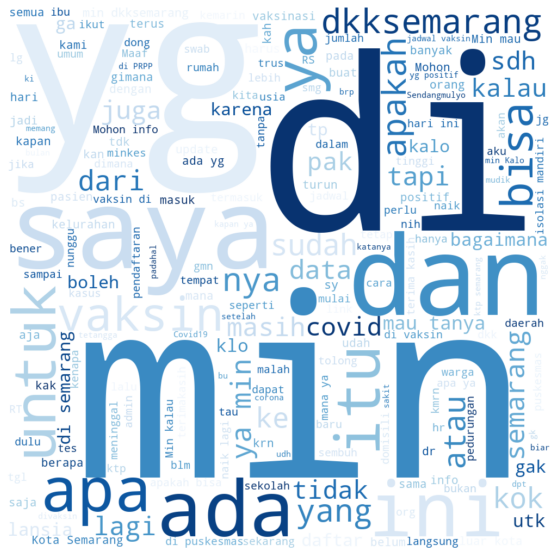

In [7]:
# neutral comments before preprocessing
data_neut = train[train['label'] == 'neutral']

all_text = ' '.join(word for word in data_neut['text'])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [8]:
# value counts
train['label'].value_counts()

neutral     2926
negative    2775
positive    2266
Name: label, dtype: int64

# Preprocess

In [9]:
train_text = train['text']
test_text = test['text']

## Rename username

In [10]:
pattern = "(?:@)([A-Za-z0-9_](?:(?:[A-Za-z0-9_]|(?:\.(?!\.))){0,28}(?:[A-Za-z0-9_]))?)"

train_text = train_text.apply(lambda x: re.sub(pattern, "@username", x))
test_text = test_text.apply(lambda x: re.sub(pattern, "@username", x))

## Cleansing

In [11]:
def cleansing(data):

    # lowercasing
    data = data.lower()

    # remove punctuation
    punct = string.punctuation
    translator = str.maketrans(punct, ' '*len(punct))
    data = data.translate(translator)

    # remove ASCII dan unicode
    # data = data.encode('ascii', 'ignore').decode('utf-8')
    # data = re.sub(r'[^\x00-\x7f]',r'', data)
    
    # remove newline
    data = data.replace('\n', ' ')

    # remove digit
    pattern = r'[0-9]'
    data = re.sub(pattern, '', data)

    # remove extra space
    data = ' '.join(data.split())
    
    return data

In [12]:
train_text = train_text.apply(lambda x: cleansing(x))
test_text = test_text.apply(lambda x: cleansing(x))

In [13]:
train_text.head()

0                                                    🔥
1                           naik turun maju canik 😂😂😂😂
2    prosentase tingkat kematian karena covid utk w...
3    rapid test test swab pcr di dkk dinkes semaran...
4                 min area pedurungan bs dilakukan dmn
Name: text, dtype: object

## Remove emojis

In [14]:
# import sys

# def remove_emoji(data):
#     emoji_pattern = re.compile("["
#                            u"\U0001F600-\U0001F64F"  # emoticons
#                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            u"\U00002702-\U000027B0"
#                            u"\U000024C2-\U0001F251"
#                            "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r' ', data)

In [15]:
# train_text = train_text.apply(lambda x: remove_emoji(x))
# test_text = test_text.apply(lambda x: remove_emoji(x))

In [16]:
# train_text.head()

# Replace emoji with text

In [17]:
df_emoji = pd.read_csv('emoji_to_text.csv')
df_emoji.head()

,emoji,makna
0,😴,Wajah Tertidur
1,🤤,Meneteskan Air Liur
2,😷,Wajah Ditutupi Masker
3,🤒,Wajah dengan Termometer
4,🤕,Wajah Diperban


In [18]:
UNICODE_EMO = {row['emoji']:row['makna'] for idx,row in df_emoji.iterrows()}

In [19]:
import emoji
import functools
import operator
import re

def convert_emojis(text):
    # split emojis
    em_split_emoji = emoji.get_emoji_regexp().split(text)
    em_split_whitespace = [substr.split() for substr in em_split_emoji]
    em_split = functools.reduce(operator.concat, em_split_whitespace)
    text = ' '.join(em_split)

    # convert emojis
    for emot in UNICODE_EMO:
        text = re.sub(r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()), text)
    return text.lower()

In [20]:
train_text = train_text.apply(lambda x: convert_emojis(x))
test_text = test_text.apply(lambda x: convert_emojis(x))

In [21]:
train.iloc[1], train_text.iloc[1]

(text        Naik Turun maju can5ik 😂😂😂😂
 label                           neutral
 username                  hadi_soeparno
 likes                                 1
 datetime                     2021-03-29
 Name: 1, dtype: object,
 'naik turun maju canik wajah_tertawa_sampai_menangis wajah_tertawa_sampai_menangis wajah_tertawa_sampai_menangis wajah_tertawa_sampai_menangis')

## Normalize kata alay/colloquial

In [22]:
# CONSTRUCT KAMUS ALAY
text_path1 = 'https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/kbba.txt'
text_path2 = 'https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv'
kamus_alay1 = pd.read_csv(text_path1, delimiter="\t", header=None, names=['slang', 'formal'])
kamus_alay2 = pd.read_csv(text_path2)
kamus_alay = pd.concat([kamus_alay1, kamus_alay2[['slang', 'formal']]]).reset_index(drop=True)

dict_alay = dict()
for index, row in kamus_alay.iterrows():
    dict_alay[row['slang']] = row['formal']

def normalize_text(data):
  word_tokens = word_tokenize(data)
  result = [dict_alay.get(w,w) for w in word_tokens]
  return ' '.join(result)

In [23]:
train_text = train_text.apply(lambda x: normalize_text(x))
test_text = test_text.apply(lambda x: normalize_text(x))

In [24]:
train_text.head()

0                                                  api
1    naik turun maju canik wajah_tertawa_sampai_men...
2    prosentase tingkat kematian karena covid untuk...
3    rapid test test swab pcr di dan kawan-kawan di...
4            min area pedurungan bisa dilakukan dimana
Name: text, dtype: object

## Spelling correction (not implemented yet)

## Remove stopwords

In [25]:
# CONSTRUCT STOPWORDS
rama_stopword = "https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/stopword.txt"
yutomo_stopword = "https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt"
fpmipa_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/fpmipa-stopwords.txt"
sastrawi_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/sastrawi-stopwords.txt"
aliakbar_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/aliakbars-bilp.txt"
pebahasa_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/pebbie-pebahasa.txt"
elang_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-id.txt"
nltk_stopword = stopwords.words('indonesian')

path_stopwords = [rama_stopword, yutomo_stopword, fpmipa_stopword, sastrawi_stopword, 
                  aliakbar_stopword, pebahasa_stopword, elang_stopword]

# CUSTOM STOPWORDS
other = '''
admin mimin min minkes kalo nya username
'''

# gabungkan stopwords
stopwords_l = nltk_stopword
for path in path_stopwords:
    response = requests.get(path)
    stopwords_l += response.text.split('\n')

st_words = set(stopwords_l)
other_stopword = set(other.split())

stop_words = st_words | other_stopword


def remove_stopword(text, stop_words=stop_words):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

In [26]:
train_text = train_text.apply(lambda x: remove_stopword(x))
test_text = test_text.apply(lambda x: remove_stopword(x))

In [27]:
train_text.head()

0                                                  api
1    turun maju canik wajah_tertawa_sampai_menangis...
2        prosentase kematian covid warga kota semarang
3    rapid test test swab pcr kawan-kawan dinkes se...
4                                      area pedurungan
Name: text, dtype: object

# Feature extraction (TF-IDF)

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, max_features = 5000, ngram_range = (1, 3),
                             sublinear_tf = True )

train_features = vectorizer.fit_transform(train_text)
test_features = vectorizer.transform(test_text)

In [29]:
train_features.toarray().shape

(7967, 5000)

# SVM

In [30]:
# mapping label
mapper = {'neutral':0, 'positive':1, 'negative':2}
train_y = train['label'].map(mapper)
test_y = test['label'].map(mapper)

train_y

0       2
1       0
2       0
3       2
4       0
       ..
7962    0
7963    0
7964    2
7965    2
7966    2
Name: label, Length: 7967, dtype: int64

In [31]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(train_features, train_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [32]:
# cross-val score
from sklearn.model_selection import cross_val_score

cross_val_score(clf, train_features, train_y, cv=5)

array([0.71706399, 0.7314931 , 0.73822976, 0.74576271, 0.72881356])

In [33]:
# predict
y_pred = clf.predict(test_features)

In [34]:
# accuracy
from sklearn.metrics import accuracy_score

accuracy_score(test_y, y_pred)

0.7449799196787149

In [36]:
from joblib import dump, load

dump(clf, 'tfidf_svc.joblib') 

['tfidf_svc.joblib']

GridSearchCV

In [ ]:
# train 1
## kernel = linear
## C = 1
## gamma = scale
## dfs = ovo

# train 2
## kernel = rbf
## C = 1
## gamma = scale
## dfs = ovo

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'kernel': ['linear', 'rbf', 'poly'],  # 3
          'C': [1, 0.25, 0.5, 0.75],            # 4
          'gamma': ['scale', 'auto', 1, 2, 3],  # 5
          'decision_function_shape': ['ovo','ovr'] # 2
          # 3 * 4 * 5 *2 * 5cv = 120 * 5 = 600 kombinasi
}

clf = SVC()
clf_grid = GridSearchCV(clf, params)
clf_grid.fit(train_features, train_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 0.25, 0.5, 0.75],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto', 1, 2, 3],
                         'kernel': ['linear', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
clf_grid.best_params_

{'C': 1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
# cross-val score
cross_val_score(clf_grid, train_features, train_y, cv=5)

array([0.7195734 , 0.73212045, 0.74011299, 0.74136849, 0.72881356])

In [ ]:
# accuracy test
y_pred = clf_grid.predict(test_features)

accuracy_score(test_y, y_pred)

0.7464859437751004

In [ ]:
from joblib import dump, load

dump(clf_grid, 'tfidf_svc_tuned.joblib') 

['tfidf_svc_tuned.joblib']

In [ ]:
a = load("svc_tuned.joblib")
b = a.predict(test_features)
accuracy_score(test_y, b)

0.7464859437751004